In [3]:
# Required packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import numpy as np
import pickle

## Autoencoder

### Prepare training images

In [10]:
# Load train set
with open('train_set.pkl', 'rb') as f:
    train_set = pickle.load(f)

In [34]:
def obtain_patches(patient_data):    
    patches = []

    # Iterate over each patient and their data
    for patient_id, entries in patient_data.items():        
        image_entries = entries[:-1]  # Exclude the last entry as it is the patient-level label
        
        # Add a tuple containing patient_id, index, and patch
        for index, patch in enumerate(image_entries):
            patches.append((patient_id, index, patch))

    return patches

# All the patches are from sane patients
train_patches = obtain_patches(train_set)


In [35]:
len(train_patches)

14130

In [ ]:
# Define transformations
transform = transforms.Compose([  
    transforms.Resize((256, 256)), # Resize images to 256x256  
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1] range
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] range
])

# Custom dataset class
class PILImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        patient_id, index, image = self.images[idx]
        patch = image['img']
        if self.transform:
            patch = self.transform(patch)
        return patch, patient_id, index  # Return the image along with its patient_id and index

# Create dataset and dataloader
traindataset = PILImageDataset(train_patches, transform=transform) 
trainloader = DataLoader(traindataset, batch_size=64, shuffle=True) 


### Model definition

In [47]:
# Create model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)   # 256x256 -> 128x128
        self.enc_relu1 = nn.ReLU(True)
        
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 128x128 -> 64x64
        self.enc_relu2 = nn.ReLU(True)
        
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1) # 64x64 -> 32x32
        self.enc_relu3 = nn.ReLU(True)
        
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1) # 32x32 -> 16x16
        self.enc_relu4 = nn.ReLU(True)
        
        # Decoder
        self.dec_conv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1) # 16x16 -> 32x32
        self.dec_relu1 = nn.ReLU(True)
        
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1) # 32x32 -> 64x64
        self.dec_relu2 = nn.ReLU(True)
        
        self.dec_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 64x64 -> 128x128
        self.dec_relu3 = nn.ReLU(True)
        
        self.dec_conv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)    # 128x128 -> 256x256
        self.dec_sigmoid = nn.Sigmoid()  # Use sigmoid for normalized RGB

    def forward(self, x):
        # Encoder path with saved activations for skipping connections
        x1 = self.enc_relu1(self.enc_conv1(x))
        x2 = self.enc_relu2(self.enc_conv2(x1))
        x3 = self.enc_relu3(self.enc_conv3(x2))
        x4 = self.enc_relu4(self.enc_conv4(x3))
        
        # Decoder path skipping one connection
        x = self.dec_relu1(self.dec_conv1(x4) + x3)  # Skip connection from x3
        x = self.dec_relu2(self.dec_conv2(x))
        x = self.dec_relu3(self.dec_conv3(x))
        x = self.dec_sigmoid(self.dec_conv4(x))
    
        return x

In [48]:
# Usage
model = ConvAutoencoder()

### Training loop

In [52]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function, optimizer and epochs
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
num_epochs = 10

In [ ]:
# Training loop
for epoch in range(num_epochs):    
    for data in trainloader:  # Assuming `dataloader` provides (images, patient_id, index) batches       

        # Unpack the data
        img, patient_id, index = data  # Unpack the image, patient_id, and index
        
        img = img.to(device)  # Move image to device
        
        # Forward pass
        output = model(img)
        
        # Assuming you want to calculate the loss between the input image and the output
        loss = criterion(output, img)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save model weights
torch.save(model.state_dict(), 'trained_model.pth')


### Evaluation loop

In [56]:
%%capture
# Load model weights
model.load_state_dict(torch.load("model_weights.pth"))

# Set model to evaluation mode
model.eval()

# Move model to the same device as data (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [85]:
# Function to perform inference on all images or a limited number, and display original and reconstructed images
def infer_and_display(dataloader, model, num_images=5, show=False, perform_inference=True):
    reconstructed_images = []  # List to store reconstructed images with metadata (only if perform_inference=True)

    # If `perform_inference` is True, perform inference on all images
    if perform_inference:
        with torch.no_grad():  # Disable gradient computation for inference
            for batch in dataloader:
                # Unpack the batch into images, patient_id, and index
                img, patient_id, index = batch
                img = img.to(device)  # Move image to device
                
                # Perform reconstruction
                reconstructed = model(img)
                
                # Move data back to CPU for storage
                img = img.cpu()
                reconstructed = reconstructed.cpu()

                # Collect reconstructed images along with their patient id and index
                for i in range(len(reconstructed)):
                    # Convert the image tensor to PIL image and unnormalize
                    original_img = ToPILImage()(img[i] * 0.5 + 0.5)  # Unnormalize the original image
                    reconstructed_img = ToPILImage()(reconstructed[i] * 0.5 + 0.5)  # Unnormalize the reconstructed image
                    
                    # Append the original and reconstructed image with patient id and index
                    reconstructed_images.append((patient_id[i], index[i].item(), reconstructed_img))

    # If `perform_inference` is False, only perform inference for `num_images` and display them
    elif not perform_inference:
        with torch.no_grad():
            num_processed = 0
            for batch in dataloader:
                if num_processed >= num_images:
                    break  # Stop once we've processed `num_images`

                # Unpack the batch into images, patient_id, and index
                img, patient_id, index = batch
                img = img.to(device)  # Move image to device
                
                # Perform reconstruction
                reconstructed = model(img)
                
                # Move data back to CPU for storage
                img = img.cpu()
                reconstructed = reconstructed.cpu()

                # Display only the first `num_images` original and reconstructed images
                for i in range(len(reconstructed)):
                    if num_processed >= num_images:
                        break  # Stop once we've processed `num_images`

                    # Convert the image tensor to PIL image and unnormalize
                    original_img = ToPILImage()(img[i] * 0.5 + 0.5)
                    reconstructed_img = ToPILImage()(reconstructed[i] * 0.5 + 0.5)                    

                    # Plot the original and reconstructed images side by side
                    if show:
                        fig, axes = plt.subplots(1, 2, figsize=(6, 3))
                        
                        # Display the original image
                        axes[0].imshow(np.asarray(original_img))
                        axes[0].set_title(f"Original")
                        axes[0].axis("off")
                        
                        # Display the reconstructed image
                        axes[1].imshow(np.asarray(reconstructed_img))
                        axes[1].set_title(f"Reconstructed")
                        axes[1].axis("off")
                        
                        plt.show()

                    num_processed += 1

    # Return reconstructed images with patient id and index only if `perform_inference=True`
    if perform_inference:
        return reconstructed_images

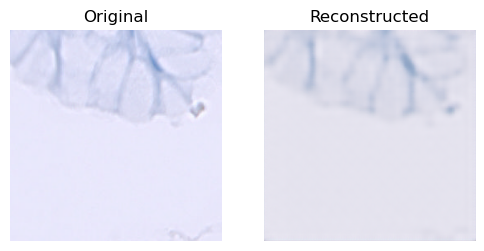

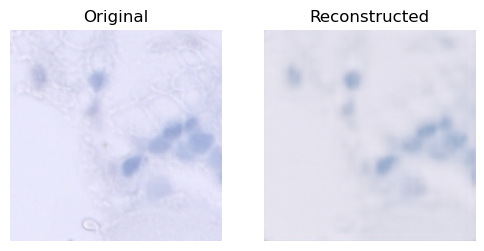

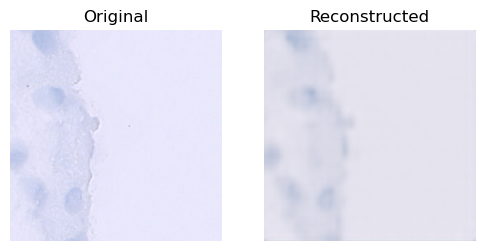

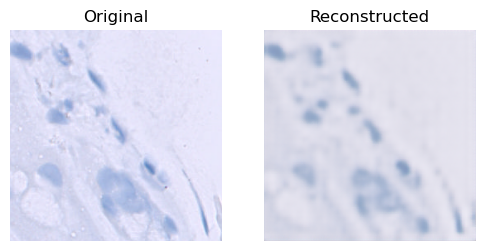

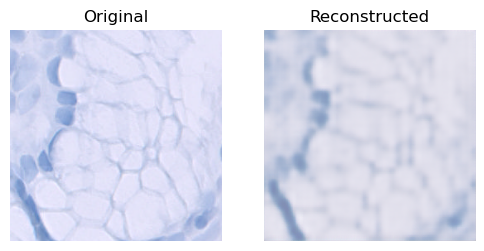

In [69]:
# Look at the performance on some training images
infer_and_display(trainloader, model, show=True, perform_inference=False)

## Test reconstruction

In [89]:
# Load test set
with open('test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [90]:
# Obtain the patches
test_patches = obtain_patches(test_set)
print(len(test_patches))

# Create dataset and dataloader
testdataset = PILImageDataset(test_patches, transform=transform) 
testloader = DataLoader(testdataset, batch_size=64, shuffle=False) 

2676


In [91]:
# Perform inference over test set
reconstructed = infer_and_display(testloader, model)

In [92]:
def update_set(dataset, reconstructed):
    
    for rec_patch in reconstructed:
        # Add reconstructed image to the correct patch in the dataset
        dataset[rec_patch[0]][rec_patch[1]]['reconstructed'] = rec_patch[2]    
    
    return dataset

In [93]:
test_set = update_set(test_set, reconstructed)

In [94]:
test_set['B22-25']

[{'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>},
 {'img': <PIL.Image.Image image mode=RGB size=256x256>,
  'label': -1,
  'reconstructed': <PIL.Image.Image image mode=RGB size=256x256>},
 {'patient_label': -1}]

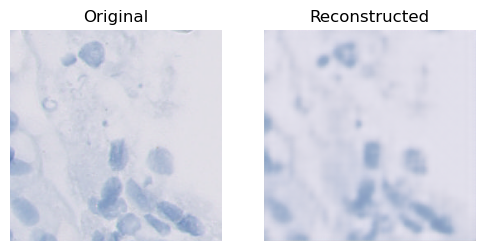

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
                        
# Display the original image
axes[0].imshow(np.asarray(test_set['B22-25'][0]['img']))
axes[0].set_title(f"Original")
axes[0].axis("off")

# Display the reconstructed image
axes[1].imshow(np.asarray(test_set['B22-25'][0]['reconstructed']))
axes[1].set_title(f"Reconstructed")
axes[1].axis("off")

plt.show()

In [96]:
# Rewrite test set
with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

## Unseen reconstruction

In [97]:
# Load unseen from pickle
with open('unseen_data.pkl', 'rb') as f:
    unseen_data = pickle.load(f)

In [98]:
# Obtain the patches
unseen_patches = obtain_patches(unseen_data)
print(len(unseen_patches))

# Create dataset and dataloader
unseendataset = PILImageDataset(unseen_patches, transform=transform) 
unseenloader = DataLoader(unseendataset, batch_size=64, shuffle=False) 

13962


In [99]:
# Perform inference over unseen set
reconstructed = infer_and_display(unseenloader, model)

In [100]:
unseen_data = update_set(unseen_data, reconstructed)

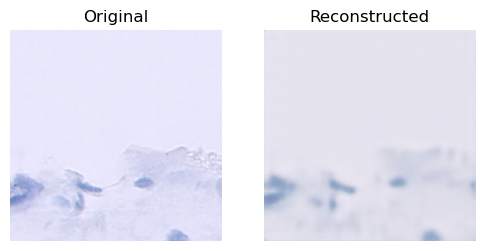

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
                        
# Display the original image
axes[0].imshow(np.asarray(unseen_data['B22-01'][0]['img']))
axes[0].set_title(f"Original")
axes[0].axis("off")

# Display the reconstructed image
axes[1].imshow(np.asarray(unseen_data['B22-01'][0]['reconstructed']))
axes[1].set_title(f"Reconstructed")
axes[1].axis("off")

plt.show()

In [103]:
# Rewrite unseen pickle
with open('unseen_data.pkl', 'wb') as f:
    pickle.dump(unseen_data, f)